In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import time
import os
import sys
from tqdm import tqdm
import shutil
import pyarrow.parquet as pq
import pyarrow as pa
from uuid import uuid4
import warnings
import subprocess
warnings.filterwarnings('ignore')

# Enhanced PyTorch and CUDA diagnostics
def check_cuda_environment():
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if not torch.cuda.is_available():
        raise RuntimeError("CUDA is not available. This notebook requires a GPU.")
    
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    
    # Test CUDA operation
    try:
        test_tensor = torch.tensor([1.0, 2.0, 3.0], device='cuda')
        test_result = test_tensor + 1
        print(f"CUDA test operation successful: {test_result}")
    except Exception as e:
        print(f"CUDA test operation failed: {e}")
        raise
    
    # Check NVIDIA driver and CUDA toolkit
    try:
        nvidia_smi = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
        print("NVIDIA-SMI output:")
        print(nvidia_smi.stdout)
    except Exception as e:
        print(f"Failed to run nvidia-smi: {e}")
    
    # Check GPU memory
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 2**30:.2f} GiB")
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(0) / 2**30:.2f} GiB")
    print(f"Reserved GPU memory: {torch.cuda.memory_reserved(0) / 2**30:.2f} GiB")

try:
    check_cuda_environment()
except Exception as e:
    print(f"Error with PyTorch or CUDA setup: {e}")
    print("Try reinstalling PyTorch: pip install torch==2.7.0 --index-url https://download.pytorch.org/whl/cu124")
    raise

# Environment diagnostics
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")
print(f"PATH: {os.environ.get('PATH')}")
print(f"Available disk space: {shutil.disk_usage('/').free / (2**30):.2f} GiB")

# Check for module shadowing
if os.path.exists('/workspace/XAI/torch.py') or os.path.exists('/workspace/XAI/torch.pyc'):
    print("Warning: Found 'torch.py' or 'torch.pyc' in /workspace/XAI. Please rename or remove it.")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration (GPU only)
device = torch.device("cuda")
print(f"Using device: {device}")

# Clear GPU memory
torch.cuda.empty_cache()
print("Cleared GPU memory cache")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU device: NVIDIA RTX A6000
GPU count: 1
Current device: 0
CUDA test operation successful: tensor([2., 3., 4.], device='cuda:0')
NVIDIA-SMI output:
Fri May  9 19:04:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:53:00.0 Off |                    0 |
| 30%   36C   

In [3]:
def load_data(data_dir="/workspace/data", file_name="merged_data.csv"):
    file_path = os.path.join(data_dir, file_name)
    alt_path = "/workspace/XAI/XAI/Predict Future Sales/merged_data.csv"
    
    if not os.path.exists(file_path):
        if os.path.exists(alt_path):
            file_path = alt_path
        else:
            raise FileNotFoundError(f"File not found at {file_path} or {alt_path}")
    
    try:
        data = pd.read_csv(file_path)
        print(f"Loaded data from {file_path}")
        print(f"Dataset shape: {data.shape}")
        print(f"Columns: {list(data.columns)}")
    except Exception as e:
        raise RuntimeError(f"Failed to load {file_path}: {e}")
    
    # Verify expected columns
    expected_columns = ['date', 'shop_id', 'item_id', 'item_name', 'item_cnt_day', 'item_price', 'item_category_id', 'shop_name', 'item_category_name', 'date_block_num']
    missing_cols = [col for col in expected_columns if col not in data.columns]
    if missing_cols:
        print(f"Warning: Missing expected columns: {missing_cols}")
    
    return data

# Load data
data = load_data()

Loaded data from /workspace/XAI/XAI/Predict Future Sales/merged_data.csv
Dataset shape: (2935849, 10)
Columns: ['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_name', 'item_category_id', 'item_category_name', 'shop_name']


In [4]:
def preprocess_data(data):
    start_time = time.time()
    
    # Early column dropping
    keep_cols = ['date', 'date_block_num', 'shop_id', 'item_id', 'item_category_id', 'item_cnt_day', 'item_price']
    data = data[keep_cols]
    print(f"Initial columns kept: {data.columns.tolist()}")
    
    # Optimize dtypes early
    data = data.astype({
        'date_block_num': 'int16',
        'shop_id': 'int32',
        'item_id': 'int32',
        'item_category_id': 'int32',
        'item_cnt_day': 'float32',
        'item_price': 'float32'
    }, errors='ignore')
    
    # Convert date to datetime
    step_time = time.time()
    data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y', errors='coerce')
    data = data[data['date'].notna()]
    print(f"Records after removing invalid dates: {len(data)}")
    print(f"Date conversion time: {time.time() - step_time:.2f} seconds")
    
    # Remove duplicates
    step_time = time.time()
    print(f"Duplicate records: {data.duplicated().sum()}")
    data = data.drop_duplicates()
    print(f"Duplicate removal time: {time.time() - step_time:.2f} seconds")
    
    # Verify no missing values
    step_time = time.time()
    print("\nMissing values before processing:")
    print(data[['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_category_id']].isna().sum())
    if data[['item_cnt_day', 'item_price']].isna().any().any():
        raise ValueError("Unexpected missing values in item_cnt_day or item_price.")
    print(f"Missing value check time: {time.time() - step_time:.2f} seconds")
    
    # Winsorization
    def winsorize_sales_chunk(chunk):
        chunk = chunk.sort_values(['shop_id', 'item_id', 'date'])
        rolling_stats = chunk.groupby(['shop_id', 'item_id'])['item_cnt_day'].rolling(window=30, min_periods=1).agg(['mean', 'std']).reset_index()
        rolling_stats['upper_bound'] = rolling_stats['mean'] + 3 * rolling_stats['std']
        rolling_stats['upper_bound'] = rolling_stats['upper_bound'].fillna(chunk['item_cnt_day'].quantile(0.99))
        
        chunk = chunk.merge(rolling_stats[['upper_bound']], left_index=True, right_index=True)
        chunk['item_cnt_day_winsor'] = np.minimum(chunk['item_cnt_day'], chunk['upper_bound'])
        chunk['is_outlier'] = chunk['item_cnt_day'] > chunk['upper_bound']
        return chunk
    
    step_time = time.time()
    chunk_size = 500000
    try:
        data = winsorize_sales_chunk(data)
    except MemoryError:
        print("MemoryError during Winsorization. Using chunked processing...")
        chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]
        data = pd.concat([winsorize_sales_chunk(chunk) for chunk in chunks], ignore_index=True)
    outlier_count = data['is_outlier'].sum()
    print(f"Outliers detected: {outlier_count} ({(outlier_count / len(data) * 100):.2f}%)")
    data = data.drop(columns=['is_outlier', 'upper_bound'])
    print(f"Winsorization time: {time.time() - step_time:.2f} seconds")
    
    # Handle negative sales
    step_time = time.time()
    data['returns'] = data['item_cnt_day_winsor'].apply(lambda x: abs(x) if x < 0 else 0)
    data['item_cnt_day_winsor'] = data['item_cnt_day_winsor'].apply(lambda x: max(0, x))
    print(f"Negative sales after processing: {(data['item_cnt_day_winsor'] < 0).sum()}")
    print(f"Negative sales handling time: {time.time() - step_time:.2f} seconds")
    
    # Aggregate to monthly level
    step_time = time.time()
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    monthly_sales = data.groupby([
        'year', 'month', 'shop_id', 'item_id', 'item_category_id', 'date_block_num'
    ], sort=False).agg({
        'item_cnt_day_winsor': 'sum',
        'returns': 'sum',
        'item_price': 'mean'
    }).reset_index()
    monthly_sales['date'] = pd.to_datetime(monthly_sales[['year', 'month']].assign(day=1))
    print(f"Monthly sales shape: {monthly_sales.shape}")
    print(f"Aggregation time: {time.time() - step_time:.2f} seconds")
    
    # Create lag features
    def create_lag_features(df):
        df = df.sort_values(['shop_id', 'item_id', 'date'])
        for lag in [1, 2, 3]:
            df[f'lag_sales_{lag}'] = df.groupby(['shop_id', 'item_id'], sort=False)['item_cnt_day_winsor'].shift(lag)
            df[f'lag_returns_{lag}'] = df.groupby(['shop_id', 'item_id'], sort=False)['returns'].shift(lag)
            df[f'lag_price_{lag}'] = df.groupby(['shop_id', 'item_id'], sort=False)['item_price'].shift(lag)
        return df
    
    step_time = time.time()
    try:
        monthly_sales = create_lag_features(monthly_sales)
    except MemoryError:
        print("MemoryError during lag feature creation. Using chunked processing...")
        chunks = [monthly_sales[i:i + chunk_size] for i in range(0, len(monthly_sales), chunk_size)]
        monthly_sales = pd.concat([create_lag_features(chunk) for chunk in chunks], ignore_index=True)
    
    # Fill NA instead of dropping
    numerical_cols = [
        'item_cnt_day_winsor', 'returns', 'item_price',
        'lag_sales_1', 'lag_sales_2', 'lag_sales_3',
        'lag_returns_1', 'lag_returns_2', 'lag_returns_3',
        'lag_price_1', 'lag_price_2', 'lag_price_3'
    ]
    monthly_sales[numerical_cols] = monthly_sales[numerical_cols].fillna(0)
    print(f"Records after creating lag features and filling NA: {len(monthly_sales)}")
    print(f"Lag feature creation time: {time.time() - step_time:.2f} seconds")
    
    # Robust scaling (fixed)
    step_time = time.time()
    scaler = RobustScaler()
    # Fit scaler on training data (date_block_num < 31)
    train_data = monthly_sales[monthly_sales['date_block_num'] < 31]
    scaler.fit(train_data[numerical_cols])
    # Apply to all data
    monthly_sales[numerical_cols] = scaler.transform(monthly_sales[numerical_cols])
    # Verify scaling
    print("Post-scaling numerical means:")
    print(monthly_sales[numerical_cols].mean())
    print(f"Robust scaling time: {time.time() - step_time:.2f} seconds")
    
    # Keep only necessary columns
    step_time = time.time()
    keep_cols = numerical_cols + ['shop_id', 'item_id', 'item_category_id', 'date', 'date_block_num']
    monthly_sales = monthly_sales[keep_cols]
    print(f"Features after preprocessing: {len(monthly_sales.columns)}")
    
    # Check for duplicate columns
    duplicate_cols = monthly_sales.columns[monthly_sales.columns.duplicated()].tolist()
    if duplicate_cols:
        print(f"Warning: Duplicate columns found: {duplicate_cols}. Removing duplicates...")
        monthly_sales = monthly_sales.loc[:, ~monthly_sales.columns.duplicated()]
        print(f"Features after removing duplicates: {len(monthly_sales.columns)}")
    
    # Optimize final dtypes
    monthly_sales = monthly_sales.astype({
        'item_cnt_day_winsor': 'float32', 'returns': 'float32', 'item_price': 'float32',
        'lag_sales_1': 'float32', 'lag_sales_2': 'float32', 'lag_sales_3': 'float32',
        'lag_returns_1': 'float32', 'lag_returns_2': 'float32', 'lag_returns_3': 'float32',
        'lag_price_1': 'float32', 'lag_price_2': 'float32', 'lag_price_3': 'float32',
        'shop_id': 'int32', 'item_id': 'int32', 'item_category_id': 'int32',
        'date_block_num': 'int16'
    }, errors='ignore')
    print(f"Final column selection and dtype optimization time: {time.time() - step_time:.2f} seconds")
    
    print(f"Total preprocessing time: {time.time() - start_time:.2f} seconds")
    return monthly_sales

# Preprocess data
monthly_sales = preprocess_data(data)

Initial columns kept: ['date', 'date_block_num', 'shop_id', 'item_id', 'item_category_id', 'item_cnt_day', 'item_price']
Records after removing invalid dates: 2935849
Date conversion time: 0.32 seconds
Duplicate records: 6
Duplicate removal time: 1.26 seconds

Missing values before processing:
date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
dtype: int64
Missing value check time: 0.05 seconds
Outliers detected: 170214 (5.80%)
Winsorization time: 18.25 seconds
Negative sales after processing: 0
Negative sales handling time: 1.30 seconds
Monthly sales shape: (1609122, 10)
Aggregation time: 0.57 seconds
Records after creating lag features and filling NA: 1609122
Lag feature creation time: 0.65 seconds
Post-scaling numerical means:
item_cnt_day_winsor    0.980713
returns                0.004689
item_price             0.633670
lag_sales_1            0.323241
lag_sales_2            0.1935

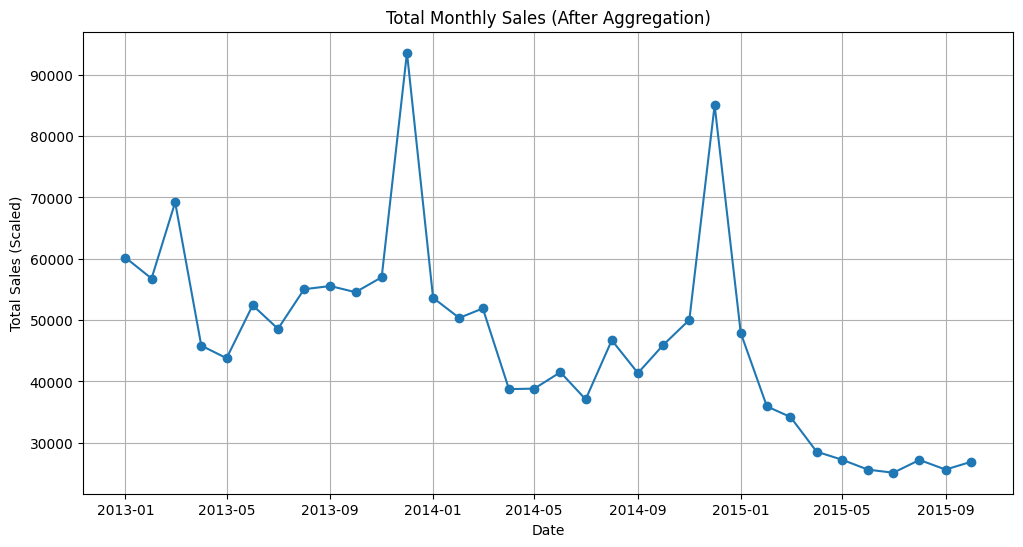

In [5]:
monthly_totals = monthly_sales.groupby('date')['item_cnt_day_winsor'].sum()
plt.figure(figsize=(12, 6))
plt.plot(monthly_totals.index, monthly_totals.values, marker='o')
plt.title('Total Monthly Sales (After Aggregation)')
plt.xlabel('Date')
plt.ylabel('Total Sales (Scaled)')
plt.grid(True)
plt.show()
plt.close()


In [6]:
def split_data(data):
    # Validate input data
    expected_cols = [
        'item_cnt_day_winsor', 'returns', 'item_price',
        'lag_sales_1', 'lag_sales_2', 'lag_sales_3',
        'lag_returns_1', 'lag_returns_2', 'lag_returns_3',
        'lag_price_1', 'lag_price_2', 'lag_price_3',
        'shop_id', 'item_id', 'item_category_id', 'date', 'date_block_num'
    ]
    missing_cols = [col for col in expected_cols if col not in data.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in data: {missing_cols}")
    
    # Check date_block_num distribution
    date_block_counts = data['date_block_num'].value_counts().sort_index()
    print("date_block_num distribution:")
    print(date_block_counts)
    
    # Verify test set exists
    if 33 not in data['date_block_num'].values:
        raise ValueError("No data for date_block_num == 33 (October 2015). Check preprocessing or dataset.")
    
    # Use date_block_num for efficient splitting
    train_data = data[data['date_block_num'] < 31]
    val_data = data[(data['date_block_num'] >= 31) & (data['date_block_num'] <= 32)]
    test_data = data[data['date_block_num'] == 33]
    
    # Define feature columns per paper, including date_block_num for SalesDataset
    numerical_cols = [
        'item_cnt_day_winsor', 'returns', 'item_price',
        'lag_sales_1', 'lag_sales_2', 'lag_sales_3',
        'lag_returns_1', 'lag_returns_2', 'lag_returns_3',
        'lag_price_1', 'lag_price_2', 'lag_price_3'
    ]
    categorical_cols = ['shop_id', 'item_id', 'item_category_id']
    feature_cols = numerical_cols + categorical_cols + ['date_block_num']
    
    # Extract features and target
    X_train = train_data[feature_cols]
    y_train = train_data['item_cnt_day_winsor']
    X_val = val_data[feature_cols]
    y_val = val_data['item_cnt_day_winsor']
    X_test = test_data[feature_cols]
    y_test = test_data['item_cnt_day_winsor']
    
    # Check for duplicate columns
    duplicate_cols = X_train.columns[X_train.columns.duplicated()].tolist()
    if duplicate_cols:
        raise ValueError(f"Duplicate columns in X_train: {duplicate_cols}")
    
    # Verify non-empty sets
    if len(X_train) == 0:
        raise ValueError("Training set is empty. Check date_block_num < 31 filter.")
    if len(X_val) == 0:
        raise ValueError("Validation set is empty. Check date_block_num 31–32 filter.")
    if len(X_test) == 0:
        raise ValueError("Test set is empty. Check date_block_num == 33 filter.")
    
    # Print statistics
    print(f"Training set size: {len(X_train)} records")
    print(f"Validation set size: {len(X_val)} records")
    print(f"Test set size: {len(X_test)} records")
    print(f"Training sales mean: {y_train.mean():.4f}, std: {y_train.std():.4f}")
    print(f"Validation sales mean: {y_val.mean():.4f}, std: {y_val.std():.4f}")
    print(f"Test sales mean: {y_test.mean():.4f}, std: {y_test.std():.4f}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Split data
X_train, y_train, X_val, y_val, X_test, y_test = split_data(monthly_sales)

date_block_num distribution:
date_block_num
0     63224
1     59935
2     63977
3     54638
4     53296
5     56196
6     58035
7     58022
8     51575
9     51090
10    51460
11    66276
12    53320
13    47704
14    49291
15    44740
16    45766
17    46481
18    45756
19    46439
20    40423
21    42595
22    45755
23    59275
24    46775
25    41390
26    40464
27    32875
28    32220
29    31909
30    33527
31    33486
32    29678
33    31529
Name: count, dtype: int64
Training set size: 1514429 records
Validation set size: 63164 records
Test set size: 31529 records
Training sales mean: 0.9894, std: 3.1360
Validation sales mean: 0.8368, std: 2.7035
Test sales mean: 0.8531, std: 2.5857


In [7]:
def save_datasets(X_train, y_train, X_val, y_val, X_test, y_test, output_dir="/workspace/processed_data"):
    os.makedirs(output_dir, exist_ok=True)
    
    # Check disk space
    total, used, free = shutil.disk_usage('/')
    free_gb = free / (2**30)
    print(f"Available disk space: {free_gb:.2f} GiB")
    if free_gb < 5:
        print("Warning: Low disk space. Free up at least 5 GiB for safe saving.")
    
    def save_parquet(df, filename, chunk_size=100000):
        try:
            duplicate_cols = df.columns[df.columns.duplicated()].tolist()
            if duplicate_cols:
                raise ValueError(f"Duplicate columns in {filename}: {duplicate_cols}")
            table = pa.Table.from_pandas(df)
            pq.write_table(table, os.path.join(output_dir, filename), compression='gzip', row_group_size=chunk_size)
            print(f"Saved {filename}")
        except OSError as e:
            print(f"Error saving {filename}: {e}")
            raise
    
    save_parquet(X_train, 'X_train_processed.parquet')
    save_parquet(y_train.to_frame(), 'y_train_processed.parquet')
    save_parquet(X_val, 'X_val_processed.parquet')
    save_parquet(y_val.to_frame(), 'y_val_processed.parquet')
    save_parquet(X_test, 'X_test_processed.parquet')
    save_parquet(y_test.to_frame(), 'y_test_processed.parquet')

# Save datasets
save_datasets(X_train, y_train, X_val, y_val, X_test, y_test)

Available disk space: 19.39 GiB
Saved X_train_processed.parquet
Saved y_train_processed.parquet
Saved X_val_processed.parquet
Saved y_val_processed.parquet
Saved X_test_processed.parquet
Saved y_test_processed.parquet


In [12]:
class SalesDataset(Dataset):
    def __init__(self, X_file, y_file, sequence_length=12, num_shops=None, num_items=None, num_categories=None):
        self.X = pq.read_table(X_file).to_pandas()
        self.y = pq.read_table(y_file).to_pandas()['item_cnt_day_winsor']
        self.sequence_length = sequence_length
        self.num_shops = num_shops
        self.num_items = num_items
        self.num_categories = num_categories
        
        self.numerical_cols = [
            'item_cnt_day_winsor', 'returns', 'item_price',
            'lag_sales_1', 'lag_sales_2', 'lag_sales_3',
            'lag_returns_1', 'lag_returns_2', 'lag_returns_3',
            'lag_price_1', 'lag_price_2', 'lag_price_3'
        ]
        self.categorical_cols = ['shop_id', 'item_id', 'item_category_id']
        
        # Validate indices
        max_shop_id = self.X['shop_id'].max()
        max_item_id = self.X['item_id'].max()
        max_category_id = self.X['item_category_id'].max()
        print(f"Max shop_id: {max_shop_id}, Max item_id: {max_item_id}, Max category_id: {max_category_id}")
        if max_shop_id >= self.num_shops:
            print(f"Warning: shop_id {max_shop_id} exceeds num_shops {self.num_shops}. Capping indices.")
            self.X['shop_id'] = self.X['shop_id'].clip(upper=self.num_shops - 1)
        if max_item_id >= self.num_items:
            print(f"Warning: item_id {max_item_id} exceeds num_items {self.num_items}. Capping indices.")
            self.X['item_id'] = self.X['item_id'].clip(upper=self.num_items - 1)
        if max_category_id >= self.num_categories:
            print(f"Warning: item_category_id {max_category_id} exceeds num_categories {self.num_categories}. Capping indices.")
            self.X['item_category_id'] = self.X['item_category_id'].clip(upper=self.num_categories - 1)
        
        self.groups = self.X.groupby(['shop_id', 'item_id'])
        self.group_keys = list(self.groups.groups.keys())
        print(f"Number of shop-item groups: {len(self.group_keys)}")
        
        # Check numerical feature stats
        print("Numerical feature means:", self.X[self.numerical_cols].mean())
    
    def __len__(self):
        return len(self.group_keys)
    
    def __getitem__(self, idx):
        shop_id, item_id = self.group_keys[idx]
        group = self.groups.get_group((shop_id, item_id)).sort_values('date_block_num')
        
        # Validate group consistency
        if group['shop_id'].nunique() > 1 or group['item_id'].nunique() > 1:
            raise ValueError(f"Group {shop_id}, {item_id} has multiple shop_id or item_id values")
        if group['item_category_id'].nunique() > 1:
            print(f"Warning: Group {shop_id}, {item_id} has multiple item_category_id values")
        
        if len(group) < self.sequence_length:
            padding = pd.DataFrame(0, index=range(self.sequence_length - len(group)), columns=group.columns)
            padding['shop_id'] = shop_id
            padding['item_id'] = item_id
            padding['item_category_id'] = group['item_category_id'].iloc[0]
            padding['date_block_num'] = group['date_block_num'].min() - 1
            if pd.isna(padding['item_category_id'].iloc[0]):
                raise ValueError(f"Invalid item_category_id in group {shop_id}, {item_id}")
            group = pd.concat([padding, group], ignore_index=True)
        
        group = group.tail(self.sequence_length)
        numerical = group[self.numerical_cols].values.astype(np.float32)
        shop_ids = group['shop_id'].values.astype(np.int64)
        item_ids = group['item_id'].values.astype(np.int64)
        category_ids = group['item_category_id'].values.astype(np.int64)
        target = self.y.loc[group.index[-1]].astype(np.float32)
        date_block_num = group['date_block_num'].iloc[-1]
        
        # Validate indices before tensor creation
        if shop_ids.max() >= self.num_shops or item_ids.max() >= self.num_items or category_ids.max() >= self.num_categories:
            raise ValueError(f"Invalid indices in group {shop_id}, {item_id}: shop_ids={shop_ids.max()}, item_ids={item_ids.max()}, category_ids={category_ids.max()}")
        
        return {
            'numerical': torch.tensor(numerical, dtype=torch.float32, device=device),
            'shop_ids': torch.tensor(shop_ids, dtype=torch.long, device=device),
            'item_ids': torch.tensor(item_ids, dtype=torch.long, device=device),
            'category_ids': torch.tensor(category_ids, dtype=torch.long, device=device),
            'target': torch.tensor(target, dtype=torch.float32, device=device),
            'date_block_num': torch.tensor(date_block_num, dtype=torch.int32, device=device),
            'identifiers': torch.tensor([shop_id, item_id, date_block_num], dtype=torch.int32, device=device)
        }

# Feature Attention
class FeatureAttention(nn.Module):
    def __init__(self, feature_dim, attention_dim=64):
        super(FeatureAttention, self).__init__()
        self.query = nn.Linear(feature_dim, attention_dim)
        self.key = nn.Linear(feature_dim, attention_dim)
        self.value = nn.Linear(feature_dim, feature_dim)
        self.scale = 1 / (attention_dim ** 0.5)
        self.softmax = nn.Softmax(dim=-1)
        
        # Initialize weights
        nn.init.xavier_uniform_(self.query.weight)
        nn.init.xavier_uniform_(self.key.weight)
        nn.init.xavier_uniform_(self.value.weight)
    
    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        scores = torch.bmm(query, key.transpose(1, 2)) * self.scale
        weights = self.softmax(scores)
        output = torch.bmm(weights, value)
        return output, weights

# HA-LSTM Model
class HALSTM(nn.Module):
    def __init__(self, num_shops, num_items, num_categories, embed_dim=16, numerical_dim=12, 
                 hidden_dim=128, num_layers=2, num_heads=4, dropout=0.1, forecast_horizon=1):
        super(HALSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.forecast_horizon = forecast_horizon
        
        # Embedding layers
        self.shop_embed = nn.Embedding(num_shops, embed_dim)
        self.item_embed = nn.Embedding(num_items, embed_dim)
        self.category_embed = nn.Embedding(num_categories, embed_dim)
        
        # Initialize embedding weights
        nn.init.uniform_(self.shop_embed.weight, -0.1, 0.1)
        nn.init.uniform_(self.item_embed.weight, -0.1, 0.1)
        nn.init.uniform_(self.category_embed.weight, -0.1, 0.1)
        
        # Total input dimension: embeddings + numerical features
        self.input_dim = embed_dim * 3 + numerical_dim
        
        # Feature Attention
        self.feature_attention = FeatureAttention(self.input_dim)
        
        # LSTM Encoder
        self.lstm = nn.LSTM(self.input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        
        # Multi-Head Attention
        self.mha = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        
        # Adaptive Fusion Layer
        self.gate = nn.Linear(hidden_dim * 2, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        
        # Multi-Horizon Decoder
        self.fc_shared = nn.Linear(hidden_dim, hidden_dim)
        self.fc_horizons = nn.ModuleList([nn.Linear(hidden_dim, 1) for _ in range(forecast_horizon)])
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
    
    def forward(self, numerical, shop_ids, item_ids, category_ids):
        batch_size, seq_len, _ = numerical.size()
        
        # Embed categorical features
        shop_embed = self.shop_embed(shop_ids)
        item_embed = self.item_embed(item_ids)
        category_embed = self.category_embed(category_ids)
        
        # Concatenate embeddings with numerical features
        x = torch.cat([numerical, shop_embed, item_embed, category_embed], dim=-1)
        
        # Feature Attention
        x, feature_weights = self.feature_attention(x)
        x = self.dropout(x)
        
        # LSTM Encoder
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_out = self.dropout(lstm_out)
        
        # Multi-Head Attention
        mha_out, mha_weights = self.mha(lstm_out, lstm_out, lstm_out)
        mha_out = self.dropout(mha_out)
        
        # Adaptive Fusion Layer
        combined = torch.cat([lstm_out[:, -1, :], mha_out[:, -1, :]], dim=-1)
        gate = self.sigmoid(self.gate(combined))
        fused = gate * lstm_out[:, -1, :] + (1 - gate) * mha_out[:, -1, :]
        
        # Multi-Horizon Decoder
        shared = self.relu(self.fc_shared(fused))
        outputs = [fc(shared) for fc in self.fc_horizons]
        output = torch.stack(outputs, dim=1).squeeze(-1)  # (batch, forecast_horizon)
        
        return output, {
            'feature_weights': feature_weights,
            'mha_weights': mha_weights,
            'fused_output': fused,
            'gate_weights': gate
        }

# Training function with tqdm progress and ETA
def train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001, lambda1=0.01, lambda2=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    interpret_outputs = {
        'sample_id': [],
        'shop_id': [],
        'item_id': [],
        'date_block_num': [],
        'feature_weights': [],
        'mha_weights': [],
        'fused_output': [],
        'gate_weights': []
    }
    
    best_val_loss = float('inf')
    
    # Epoch progress bar
    for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):
        model.train()
        train_loss = 0
        start_time = time.time()
        
        # Batch progress bar
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", total=len(train_loader), unit="batch", leave=False):
            numerical = batch['numerical']
            shop_ids = batch['shop_ids']
            item_ids = batch['item_ids']
            category_ids = batch['category_ids']
            target = batch['target']
            identifiers = batch['identifiers']
            
            optimizer.zero_grad()
            try:
                output, interpret_data = model(numerical, shop_ids, item_ids, category_ids)
            except RuntimeError as e:
                print(f"CUDA error during forward pass: {e}")
                torch.cuda.empty_cache()
                raise
            
            mse_loss = criterion(output[:, -1], target)
            att_reg = lambda1 * torch.mean(torch.sum(interpret_data['feature_weights'] ** 2, dim=-1))
            temp_reg = lambda2 * torch.mean((output[:, 1:] - output[:, :-1]) ** 2) if output.shape[1] > 1 else 0
            loss = mse_loss + att_reg + temp_reg
            
            try:
                loss.backward()
                optimizer.step()
            except RuntimeError as e:
                print(f"CUDA error during backward pass: {e}")
                torch.cuda.empty_cache()
                raise
            
            train_loss += loss.item()
            
            sample_id = str(uuid4())
            interpret_outputs['sample_id'].append(sample_id)
            interpret_outputs['shop_id'].append(identifiers[:, 0].cpu().numpy()[0])
            interpret_outputs['item_id'].append(identifiers[:, 1].cpu().numpy()[0])
            interpret_outputs['date_block_num'].append(identifiers[:, 2].cpu().numpy()[0])
            interpret_outputs['feature_weights'].append(interpret_data['feature_weights'].detach().cpu().numpy())
            interpret_outputs['mha_weights'].append(interpret_data['mha_weights'].detach().cpu().numpy())
            interpret_outputs['fused_output'].append(interpret_data['fused_output'].detach().cpu().numpy())
            interpret_outputs['gate_weights'].append(interpret_data['gate_weights'].detach().cpu().numpy())
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                numerical = batch['numerical']
                shop_ids = batch['shop_ids']
                item_ids = batch['item_ids']
                category_ids = batch['category_ids']
                target = batch['target']
                output, _ = model(numerical, shop_ids, item_ids, category_ids)
                loss = criterion(output[:, -1], target)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        scheduler.step(val_loss)
        
        # Calculate ETA
        epoch_time = time.time() - start_time
        remaining_epochs = num_epochs - (epoch + 1)
        eta_seconds = epoch_time * remaining_epochs
        eta_str = f"{int(eta_seconds // 3600)}h {int((eta_seconds % 3600) // 60)}m {int(eta_seconds % 60)}s"
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"GPU Memory: {torch.cuda.memory_allocated(0) / 2**30:.2f} GiB, ETA: {eta_str}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join('/workspace/processed_data', 'best_ha_lstm.pth'))
    
    interpret_df = pd.DataFrame({
        'sample_id': interpret_outputs['sample_id'],
        'shop_id': interpret_outputs['shop_id'],
        'item_id': interpret_outputs['item_id'],
        'date_block_num': interpret_outputs['date_block_num']
    })
    interpret_df.to_csv(os.path.join('/workspace/processed_data', 'interpret_indices.csv'), index=False)
    np.save(os.path.join('/workspace/processed_data', 'feature_weights.npy'), np.stack(interpret_outputs['feature_weights']))
    np.save(os.path.join('/workspace/processed_data', 'mha_weights.npy'), np.stack(interpret_outputs['mha_weights']))
    
    fused_df = pd.DataFrame(
        interpret_outputs['fused_output'],
        columns=[f'fused_dim_{i}' for i in range(interpret_outputs['fused_output'].shape[1])]
    )
    fused_df = pd.concat([interpret_df, fused_df], axis=1)
    fused_df.to_csv(os.path.join('/workspace/processed_data', 'fused_output.csv'), index=False)
    
    np.save(os.path.join('/workspace/processed_data', 'gate_weights.npy'), np.stack(interpret_outputs['gate_weights']))
    
    return model

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    criterion = nn.MSELoss()
    test_loss = 0
    predictions, targets = [], []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
            numerical = batch['numerical']
            shop_ids = batch['shop_ids']
            item_ids = batch['item_ids']
            category_ids = batch['category_ids']
            target = batch['target']
            output, _ = model(numerical, shop_ids, item_ids, category_ids)
            loss = criterion(output[:, -1], target)
            test_loss += loss.item()
            predictions.append(output[:, -1].cpu().numpy())
            targets.append(target.cpu().numpy())
    
    test_loss /= len(test_loader)
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    rmse = np.sqrt(test_loss)
    mae = np.mean(np.abs(predictions - targets))
    mape = np.mean(np.abs((predictions - targets) / (targets + 1e-10))) * 100
    
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test MAPE: {mape:.2f}%")
    
    return predictions, targets

# Visualization function
def visualize_attention(model, val_loader):
    model.eval()
    with torch.no_grad():
        batch = next(iter(val_loader))
        numerical = batch['numerical']
        shop_ids = batch['shop_ids']
        item_ids = batch['item_ids']
        category_ids = batch['category_ids']
        _, interpret_data = model(numerical, shop_ids, item_ids, category_ids)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(interpret_data['feature_weights'][0].cpu().numpy(), cmap='viridis')
        plt.title('Feature Attention Weights (First Sample)')
        plt.xlabel('Feature Index')
        plt.ylabel('Sequence Position')
        plt.savefig(os.path.join('/workspace/processed_data', 'feature_attention.png'))
        plt.close()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(interpret_data['mha_weights'][0].cpu().numpy(), cmap='viridis')
        plt.title('Multi-Head Attention Weights (First Sample)')
        plt.xlabel('Time Step')
        plt.ylabel('Time Step')
        plt.savefig(os.path.join('/workspace/processed_data', 'mha_attention.png'))
        plt.close()
        print("Saved attention weight visualizations to /workspace/processed_data")

# Create datasets and loaders
sequence_length = 12
batch_size = 32
numerical_dim = len([
    'item_cnt_day_winsor', 'returns', 'item_price',
    'lag_sales_1', 'lag_sales_2', 'lag_sales_3',
    'lag_returns_1', 'lag_returns_2', 'lag_returns_3',
    'lag_price_1', 'lag_price_2', 'lag_price_3'
])

# Compute max indices across all splits
monthly_sales_all = pd.concat([
    pq.read_table('/workspace/processed_data/X_train_processed.parquet').to_pandas(),
    pq.read_table('/workspace/processed_data/X_val_processed.parquet').to_pandas(),
    pq.read_table('/workspace/processed_data/X_test_processed.parquet').to_pandas()
])
num_shops = monthly_sales_all['shop_id'].max() + 1
num_items = monthly_sales_all['item_id'].max() + 1
num_categories = monthly_sales_all['item_category_id'].max() + 1
print(f"Computed num_shops: {num_shops}, num_items: {num_items}, num_categories: {num_categories}")

train_dataset = SalesDataset(
    os.path.join('/workspace/processed_data', 'X_train_processed.parquet'),
    os.path.join('/workspace/processed_data', 'y_train_processed.parquet'),
    sequence_length,
    num_shops,
    num_items,
    num_categories
)
val_dataset = SalesDataset(
    os.path.join('/workspace/processed_data', 'X_val_processed.parquet'),
    os.path.join('/workspace/processed_data', 'y_val_processed.parquet'),
    sequence_length,
    num_shops,
    num_items,
    num_categories
)
test_dataset = SalesDataset(
    os.path.join('/workspace/processed_data', 'X_test_processed.parquet'),
    os.path.join('/workspace/processed_data', 'y_test_processed.parquet'),
    sequence_length,
    num_shops,
    num_items,
    num_categories
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Train loader batches: {len(train_loader)}, Val loader batches: {len(val_loader)}, Test loader batches: {len(test_loader)}")

# Clear GPU memory before training
torch.cuda.empty_cache()
print(f"GPU Memory Allocated before training: {torch.cuda.memory_allocated(0) / 2**30:.2f} GiB")

# Initialize and train model
try:
    model = HALSTM(
        num_shops=num_shops,
        num_items=num_items,
        num_categories=num_categories,
        embed_dim=16,
        numerical_dim=numerical_dim,
        hidden_dim=128,
        num_layers=2,
        num_heads=4,
        dropout=0.1,
        forecast_horizon=1
    )
    print("Model initialized successfully")
    model = model.to(device)
    print("Model moved to GPU successfully")
except RuntimeError as e:
    print(f"Error during model initialization or moving to GPU: {e}")
    raise

model = train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001)
print("Model training complete. Best model saved to /workspace/processed_data/best_ha_lstm.pth")

# Evaluate model
predictions, targets = evaluate_model(model, test_loader)

# Visualize attention
visualize_attention(model, val_loader)

print("Training, evaluation, and visualization complete. All outputs saved in /workspace/processed_data.")


Computed num_shops: 60, num_items: 22170, num_categories: 84


Max shop_id: 59, Max item_id: 22169, Max category_id: 83
Number of shop-item groups: 406462
Numerical feature means: item_cnt_day_winsor    0.989370
returns                0.004723
item_price             0.608541
lag_sales_1            0.325077
lag_sales_2            0.192508
lag_sales_3            1.172488
lag_returns_1          0.003681
lag_returns_2          0.002879
lag_returns_3          0.002328
lag_price_1            0.461323
lag_price_2            0.668165
lag_price_3            1.062418
dtype: float32
Max shop_id: 59, Max item_id: 22167, Max category_id: 83
Number of shop-item groups: 49945
Numerical feature means: item_cnt_day_winsor    0.836846
returns                0.004164
item_price             0.944988
lag_sales_1            0.306048
lag_sales_2            0.220672
lag_sales_3            1.376550
lag_returns_1          0.003436
lag_returns_2          0.003261
lag_returns_3          0.003008
lag_price_1            0.836139
lag_price_2            1.243780
lag_price_3     

Epochs:   0%|          | 0/50 [00:22<?, ?epoch/s]


KeyboardInterrupt: 